This program is a test program to run the seqnmf code!

The result is unsatisfactory, so please use this notebook as a reference to getting more familiar with seqnmf in python. Also please refer to the code using orginal data for better results.

First to run this test program on Google Colab, we need to first execute the following command to install seqnmf package.

Command: pip install seqnmf

In [ ]:
!pip install seqnmf

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import h5py
import scipy.io as sio

In [ ]:
# This is the datapath for the downsampled data.
# In this test program, the image is downsampled 10x so the result is not good at all.
# The size of each downsampled frame is 18x20.

downsample_data ="image_downsampled_x10.mat"

In [ ]:
# The following code reads the downsampled data(in .mat format).
# What we are using is the transposed matrix of the data.
# The shape of the transposed data is 360x38000, which is what we will use for seqnmf.

with h5py.File(downsample_data) as f:
  downsampled_data = f['image_downsample_10'].value

downsampled_data = np.transpose(downsampled_data)
print(downsampled_data.shape)

(360, 38000)


In [ ]:
# The following code will do a rescaling to current data.
# For the data of each neuron(pixel), the rescaling set the value above mean+2std to be min, and rescale all the data to [0,1]

for i in range(len(downsampled_data)):
  data_for_single_neuron = downsampled_data[i]
  neuron_std, neuron_min, neuron_max = np.std(data_for_single_neuron), np.amin(data_for_single_neuron), np.amax(data_for_single_neuron)
  twostd = neuron_min + 2*neuron_std
  data_for_single_neuron[data_for_single_neuron > twostd] = neuron_min
  data_for_single_neuron = data_for_single_neuron - neuron_min
  data_for_single_neuron = data_for_single_neuron/(neuron_max - neuron_min)
  downsampled_data[i] = data_for_single_neuron

In [ ]:
# The method python storing matrix is not the same with the one in matla. So we need to reshape it to (20,18) and get the transposed data.
# In this function it does the reshape and then return the transposed data.

def reshape_img(data):
  image1000py=np.reshape(data,(20,18))
  image1000py=np.transpose(image1000py)
  return image1000py

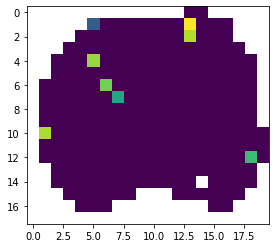

In [ ]:
# This code displays the frame 2000

image1000=downsampled_data[:,2000]
image1000py = reshape_img(image1000)
plt.imshow(image1000py)

# print(image1000)
plt.show()

In [ ]:
# In displaying the data we want to set the background to be nan, while when running the seqnmf we need to set it to 0.
# So I want to find which index represents the background.

edge_pos = np.isnan(image1000py)

In [ ]:
# Change nan to 0 to feed in the seqnnmf.

where_are_NaNs = np.isnan(downsampled_data)
downsampled_data[where_are_NaNs] = 0

In [ ]:
# We feed the first 2000 frames in the seqnmf. You can set any value you like

test_data = downsampled_data[:,:2000]

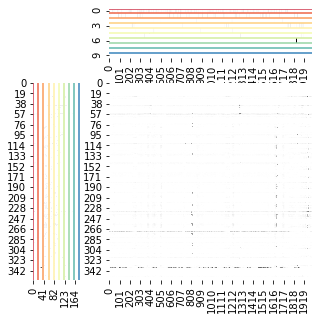

In [ ]:
# Calling the seqnmf algorithm.
# K = 10, L = 20, Lambda = 0.001

from seqnmf import seqnmf, plot, example_data

[W, H, cost, loadings, power] = seqnmf(test_data, K=10, L=20, Lambda=0.001, plot_it=False)

plot(W, H).show()

In [ ]:
print(test_data.shape)
# Number of features is 75. Number of timepoints is 666.
print(W.shape)
# Num of factors is 20. Num of sequence length is 100.
print(H.shape)
# W is features*factors*sequence
# H is factors*timepoints

(360, 2000)
(360, 10, 20)
(10, 2000)


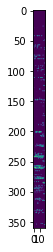

In [ ]:
# This displays the pattern id 3 in pattern matrix W.
# pattern id 0-9

plt.imshow(W[:,3,:])

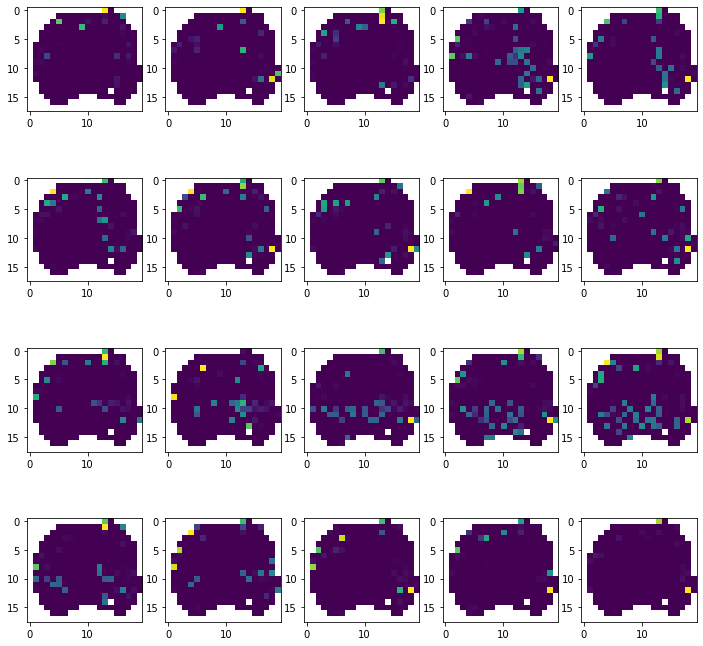

In [ ]:
# display Pattern 3 in detail.

fig=plt.figure(figsize=(12, 12))
columns = 5
rows = 4
pattern_id = 3
for i in range(1, columns*rows+1):
    img = reshape_img(W[:,pattern_id,i-1])
    img[edge_pos] = np.nan
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

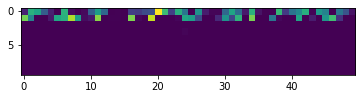

In [ ]:
# How the patterns are happening in the period frame 100-150.

plt.imshow(H[:,100:150])

In [ ]:
# index_list = np.arange(1, 76)
# columns_list = np.arange(1, 667)
# example_data_df = pd.DataFrame(data = example_data, index = index_list, columns = columns_list)
# print(example_data_df)
# print(example_data.max())
# print(example_data.min())
# min_value = example_data.min()
# max_value = example_data.max()

The code below is written while I'm still learning seqnmf. I guess it will not help you a lot lol.

In [ ]:
# This code is further used to display the example data provided by seqnmf.
# You can skip this if u like! It is not that useful.

def draw_fig(ndarray_data, save_fig_name, diff):
  new_info_array = []
  for i in range(len(ndarray_data)):
    for j in range(len(ndarray_data[i])):
      plot_color = float(ndarray_data[i][j])/diff
      new_info_array.append([j,i,plot_color])
  for i in new_info_array:
    fill_in_x = [i[0], i[0]+1]
    fill_in_y1 = [i[1], i[1]]
    fill_in_y2 = [i[1]+1, i[1]+1]
    plt.fill_between(fill_in_x, fill_in_y1, fill_in_y2, color = str(1-i[2]))

  plt.savefig(save_fig_name)
  plt.show()

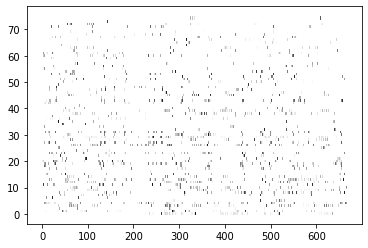

In [ ]:
draw_fig(example_data)

In [ ]:
# Silly code since I'm not sure about the result of reshape.
# Please use reshape.

def divide_W_into_pattern(W, N, K, L):
  all_pattern = []
  for i in range(K):
    pattern_detail = []
    for j in range(N):
      pattern_detail.append(W[j][i])
    all_pattern.append(pattern_detail)
  all_pattern = np.array(all_pattern)
  return all_pattern

In [ ]:
pattern_matrix = divide_W_into_pattern(W, 75, 20, 100)
print(pattern_matrix.shape)

(20, 75, 100)


0.0 1.3568110221727576


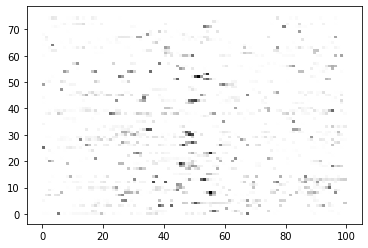

In [ ]:
print(pattern_matrix[0].min(), pattern_matrix[0].max())
diff = pattern_matrix.max() - pattern_matrix.min()
draw_fig(pattern_matrix[0], 'pattern_0', diff)

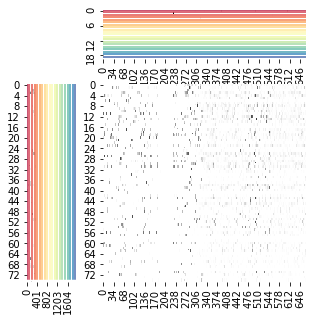

In [ ]:
plot(W, H).savefig('seqnmf_result.png')